# Kaggle 腰椎変性疾患分類
* タイトル
    * [RSNA 2024 Lumbar Spine Degenerative Classification](https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification)
* 内容
    * このコンテストの目標は、腰椎 MR 画像を使用して変性脊椎疾患の検出と分類を支援するために使用できるモデルを作成することです。参加者は、脊椎疾患の診断における放射線科医の作業をシミュレートするモデルを開発します。
* 期間
    * 2024.05.16-2024.10.01
* 評価方法
    * サンプル加重ログ損失の平均
        * 予測の評価に使用される主要なメトリックは、サンプルごとに加重されたログ損失の平均。
        * 各サンプルには異なる重みが与えられる
            * 正常/軽度 (normal/mild): 重みは 1
            * 中程度 (moderate): 重みは 2
            * 重度 (severe): 重みは 4
    * any_severe_spinal メトリック
        * any_severe_scalar が 1.0 に設定(これは、重度の状態が最も重要視されていることを示す)

---

# ライブラリ

In [2]:
# pip install pydicom

In [3]:
import pandas as pd
import numpy as np

#画像表示
from PIL import Image

#DICOMファイルの読み込みと表示用
import shutil #zipファイルの解凍
import pydicom # ※拡張子.dcmは医療用画像形式ファイルであるため、pythonで読み込むにはpydicomをインポートする必要がある。
import matplotlib.pyplot as plt

---

# データの確認

【このチャレンジでは、左神経孔狭窄、右神経孔狭窄、左関節下狭窄、右関節下狭窄、脊柱管狭窄という 5 つの腰椎変性疾患の分類に焦点を当てます。データセット内の各画像検査では、椎間板レベル L1/L2、L2/L3、L3/L4、L4/L5、L5/S1 の 5 つの疾患それぞれについて、重症度スコア (正常/軽度、中等度、重度) を提供しています。】

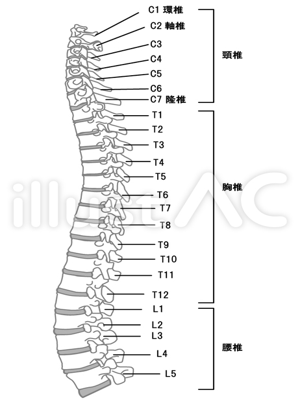

In [4]:
img1 = Image.open('images\sekitui.jpeg')
new_size = (300, 400) 
resized_img = img1.resize(new_size)

resized_img

腰椎はL1～L5の5つの椎骨で形成される。<br>
その椎骨の間（椎間孔）から腰神経が左右に5対伸びている。<br>
この神経が椎間板や椎骨に圧迫されることで腰痛を引き起こす。<br>
腰神経の通路が狭くなり神経を圧迫、つまり狭窄する状態を作り疼痛や痺れなどの症状がでることを総称して腰椎変形性疾患と呼ぶ。

## train.csvの確認

In [5]:
df_train = pd.read_csv('train.csv')
df_train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

In [7]:
rows_with_missing_values = df_train[df_train.isna().any(axis=1)]
rows_with_missing_values

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
16,46494080,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,NaN,Normal/Mild,Moderate,Moderate,NaN,NaN,Moderate,Moderate,Normal/Mild
24,64092030,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,NaN,Normal/Mild,NaN,Moderate,Moderate,NaN,Moderate,NaN,Normal/Mild,Normal/Mild
30,74782131,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
43,97086905,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
73,159721286,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,...,NaN,NaN,Normal/Mild,Moderate,Normal/Mild,NaN,NaN,Moderate,Severe,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,4140710202,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1911,4146959702,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1925,4175603528,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1950,4232806580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,NaN,Moderate,Moderate,Moderate,NaN,NaN,Normal/Mild,Moderate,Normal/Mild


* study_id- 研究 ID
    * 各研究には複数の画像シリーズが含まれる場合があります。
* [condition]_[level]等
    * spinal_canal_stenosis_l1_l2重大度レベルはNormal/Mild、  Moderate、またはSevere。一部のエントリのラベルは不完全です。

In [8]:
'''label_columns = df_train.columns[1:]
label_distribution = df_train[label_columns].melt().groupby(['variable', 'value']).size().reset_index(name='count').sort_values('variable')# ラベルの分布を計算
label_distribution.to_csv('df_label_distribution.csv', index=False)#データフレーム化'''

"label_columns = df_train.columns[1:]\nlabel_distribution = df_train[label_columns].melt().groupby(['variable', 'value']).size().reset_index(name='count').sort_values('variable')# ラベルの分布を計算\nlabel_distribution.to_csv('df_label_distribution.csv', index=False)#データフレーム化"

In [9]:
'''pd.set_option('display.max_rows', None)# 全ての行を表示するための設定
df_label_distribution = pd.read_csv('df_label_distribution.csv')# CSVファイルの読み込み
df_label_distribution# データフレームを表示'''

"pd.set_option('display.max_rows', None)# 全ての行を表示するための設定\ndf_label_distribution = pd.read_csv('df_label_distribution.csv')# CSVファイルの読み込み\ndf_label_distribution# データフレームを表示"

## train_label_coordinates.csvの確認

In [10]:
df_train_label = pd.read_csv('train_label_coordinates.csv')
df_train_label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


* series_id
    * 画像シリーズ ID。
* instance_number
    * 3D スタック内の画像の順序番号。
* condition
    * 中核となる病状は、脊柱管狭窄症、神経孔狭窄症、関節下狭窄症の 3 つです。
    * 最後の 2 つは、脊椎の両側で考慮されます。
* level
    * 関連する椎骨、例えばl3_l4
* [x/y]
    * ラベルを定義する領域の中心の x/y 座標。

In [11]:
'''zip_file = 'train_images.zip'# 展開したいzipファイルのパス
extract_to = 'train_images'# 展開先のディレクトリ
shutil.unpack_archive(zip_file, extract_to)# Zipファイルを展開する

print(f'{zip_file} を {extract_to} に展開しました。')'''

"zip_file = 'train_images.zip'# 展開したいzipファイルのパス\nextract_to = 'train_images'# 展開先のディレクトリ\nshutil.unpack_archive(zip_file, extract_to)# Zipファイルを展開する\n\nprint(f'{zip_file} を {extract_to} に展開しました。')"

## train_series_descriptionの確認

In [12]:
df_train_desc = pd.read_csv('train_series_descriptions.csv')
df_train_desc

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


## train_imagesの確認

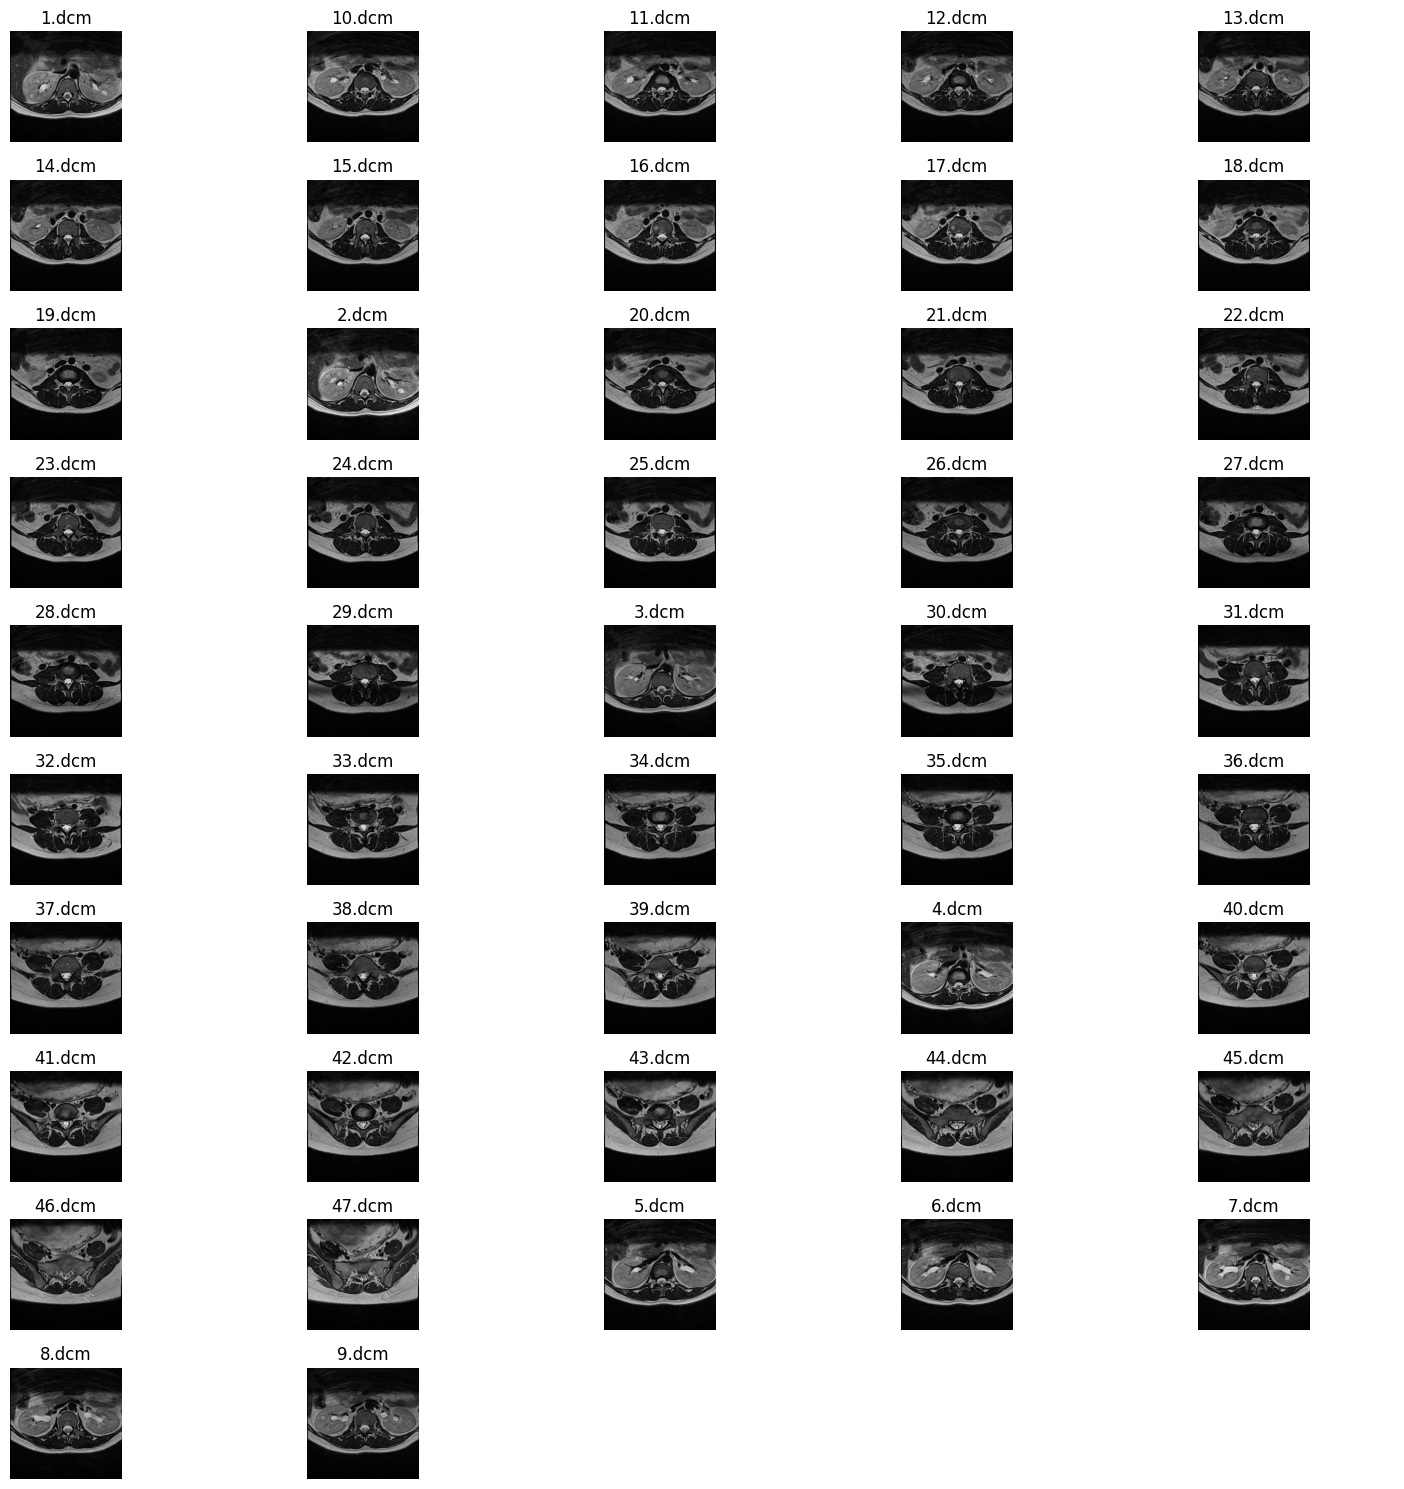

In [13]:
import os
from math import ceil
# DICOMファイルが保存されているディレクトリパス
dicom_dir = 'train_images/4244280214/2896011508'

# ディレクトリ内のすべてのDICOMファイルのリストを取得
dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

# 表示設定
num_columns = 5
num_rows = ceil(len(dicom_files) / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

# DICOMファイルを順番に読み込んで表示
for idx, filename in enumerate(dicom_files):
    dicom_file_path = os.path.join(dicom_dir, filename)
    dicom_image = pydicom.dcmread(dicom_file_path)
    image_data = dicom_image.pixel_array
    
    row_idx = idx // num_columns
    col_idx = idx % num_columns
    
    axes[row_idx, col_idx].imshow(image_data, cmap='gray')
    axes[row_idx, col_idx].axis('off')  # 軸を非表示にする場合
    axes[row_idx, col_idx].set_title(filename)  # 画像のタイトルにファイル名を表示

# 余分なプロットを非表示にする
for i in range(len(dicom_files), num_rows * num_columns):
    row_idx = i // num_columns
    col_idx = i % num_columns
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

## test_imagesの確認

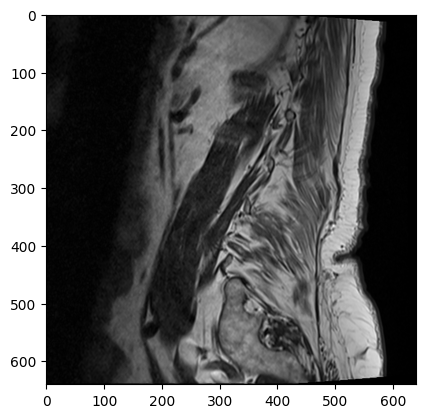

In [14]:
file_path_2 = 'test_images/44036939/2828203845/1.dcm'
ds = pydicom.dcmread(file_path_2)

image_2828203845_1 = ds.pixel_array

plt.imshow(image_2828203845_1, cmap='gray')
plt.show()

---

# 前処理

データがバラバラで混乱する。

df_train (= train.csv)のstudy_idと疾患部位が一致する重症度を、df_train_label_coodinates (= train_label_coodinates.csv)に結合する。

In [15]:
df_train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [16]:
columns = df_train.columns
print(columns)

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

In [17]:
name_counts = df_train_label['condition'].value_counts()
print(name_counts)

condition
Left Neural Foraminal Narrowing     9860
Right Neural Foraminal Narrowing    9859
Spinal Canal Stenosis               9753
Right Subarticular Stenosis         9612
Left Subarticular Stenosis          9608
Name: count, dtype: int64


In [18]:
name_counts = df_train_label['level'].value_counts()
print(name_counts)

level
L3/L4    9858
L4/L5    9858
L5/S1    9845
L2/L3    9661
L1/L2    9470
Name: count, dtype: int64


In [19]:
df_train

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


df_trainのカラム名と一致させたいので、conditionとlavelを' 'を挟んで統合する。

In [20]:
df_train_label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [21]:
def transform_string(s):
    return s.lower().replace(' ', '_').replace('/', '_')

df_train_label['condition'] = df_train_label['condition'].map(transform_string)
df_train_label['level'] = df_train_label['level'].map(transform_string)
df_train_label

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,219.465940,97.831063
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,205.340599,140.207084
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,202.724796,181.013624
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,202.933333,219.733333


In [22]:
df_train_label['condition_level'] = df_train_label['condition'] + '_' + df_train_label['level']
df_train_label

,study_id,series_id,instance_number,condition,level,x,y,condition_level
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602,spinal_canal_stenosis_l1_l2
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286,spinal_canal_stenosis_l2_l3
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182,spinal_canal_stenosis_l3_l4
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434,spinal_canal_stenosis_l4_l5
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602,spinal_canal_stenosis_l5_s1
...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,219.465940,97.831063,left_neural_foraminal_narrowing_l1_l2
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,205.340599,140.207084,left_neural_foraminal_narrowing_l2_l3
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,202.724796,181.013624,left_neural_foraminal_narrowing_l3_l4
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,202.933333,219.733333,left_neural_foraminal_narrowing_l4_l5


In [23]:
df_train_label['row_id'] = df_train_label['study_id'].astype(str) + '_' + df_train_label['condition_level']
df_train_label

,study_id,series_id,instance_number,condition,level,x,y,condition_level,row_id
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602,spinal_canal_stenosis_l1_l2,4003253_spinal_canal_stenosis_l1_l2
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286,spinal_canal_stenosis_l2_l3,4003253_spinal_canal_stenosis_l2_l3
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182,spinal_canal_stenosis_l3_l4,4003253_spinal_canal_stenosis_l3_l4
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434,spinal_canal_stenosis_l4_l5,4003253_spinal_canal_stenosis_l4_l5
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602,spinal_canal_stenosis_l5_s1,4003253_spinal_canal_stenosis_l5_s1
...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,219.465940,97.831063,left_neural_foraminal_narrowing_l1_l2,4290709089_left_neural_foraminal_narrowing_l1_l2
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,205.340599,140.207084,left_neural_foraminal_narrowing_l2_l3,4290709089_left_neural_foraminal_narrowing_l2_l3
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,202.724796,181.013624,left_neural_foraminal_narrowing_l3_l4,4290709089_left_neural_foraminal_narrowing_l3_l4
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,202.933333,219.733333,left_neural_foraminal_narrowing_l4_l5,4290709089_left_neural_foraminal_narrowing_l4_l5


In [24]:
df_train_label['img_path'] = 'train_images_jpg/' + df_train_label['study_id'].astype(str) + '/' + df_train_label['series_id'].astype(str) + '/' + df_train_label['instance_number'].astype(str) + '.jpg'
df_train_label

,study_id,series_id,instance_number,condition,level,x,y,condition_level,row_id,img_path
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602,spinal_canal_stenosis_l1_l2,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286,spinal_canal_stenosis_l2_l3,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182,spinal_canal_stenosis_l3_l4,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434,spinal_canal_stenosis_l4_l5,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602,spinal_canal_stenosis_l5_s1,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg
...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,219.465940,97.831063,left_neural_foraminal_narrowing_l1_l2,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,205.340599,140.207084,left_neural_foraminal_narrowing_l2_l3,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,202.724796,181.013624,left_neural_foraminal_narrowing_l3_l4,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,202.933333,219.733333,left_neural_foraminal_narrowing_l4_l5,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg


In [25]:
df_train_label['img_path_dcm'] = 'train_images/' + df_train_label['study_id'].astype(str) + '/' + df_train_label['series_id'].astype(str) + '/' + df_train_label['instance_number'].astype(str) + '.dcm'
df_train_label

,study_id,series_id,instance_number,condition,level,x,y,condition_level,row_id,img_path,img_path_dcm
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,322.831858,227.964602,spinal_canal_stenosis_l1_l2,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,320.571429,295.714286,spinal_canal_stenosis_l2_l3,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,323.030303,371.818182,spinal_canal_stenosis_l3_l4,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,335.292035,427.327434,spinal_canal_stenosis_l4_l5,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,353.415929,483.964602,spinal_canal_stenosis_l5_s1,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,219.465940,97.831063,left_neural_foraminal_narrowing_l1_l2,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,205.340599,140.207084,left_neural_foraminal_narrowing_l2_l3,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,202.724796,181.013624,left_neural_foraminal_narrowing_l3_l4,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,202.933333,219.733333,left_neural_foraminal_narrowing_l4_l5,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm


df_trainとdf_train_labelをdf_train_margedにまとめる。

In [26]:
df_merged = pd.merge(df_train_label, df_train, on=['study_id'], how='left')

# condition_levelより左のカラムについて、条件に一致する列の値をseverityに入れる
conditions = df_merged['condition_level'].tolist()
severity_values = []
for idx, row in df_merged.iterrows():
    severity = None
    for col in df_merged.columns:
        if col == row['condition_level']:
            severity = row[col]
            break
    severity_values.append(severity)

df_merged['severity'] = severity_values

# 不要な列を削除
columns_to_keep = ['study_id', 'series_id', 'instance_number', 'condition', 'level', 'condition_level', 'x', 'y',  'row_id', 'img_path','img_path_dcm', 'severity']
df_summary = df_merged[columns_to_keep]

df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild


In [27]:
df_summary.head(25)

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild
5,4003253,1054713880,4,right_neural_foraminal_narrowing,l4_l5,right_neural_foraminal_narrowing_l4_l5,187.961759,251.839388,4003253_right_neural_foraminal_narrowing_l4_l5,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Moderate
6,4003253,1054713880,4,right_neural_foraminal_narrowing,l5_s1,right_neural_foraminal_narrowing_l5_s1,198.240918,285.613767,4003253_right_neural_foraminal_narrowing_l5_s1,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Normal/Mild
7,4003253,1054713880,5,right_neural_foraminal_narrowing,l3_l4,right_neural_foraminal_narrowing_l3_l4,187.227533,210.722753,4003253_right_neural_foraminal_narrowing_l3_l4,train_images_jpg/4003253/1054713880/5.jpg,train_images/4003253/1054713880/5.dcm,Moderate
8,4003253,1054713880,6,right_neural_foraminal_narrowing,l1_l2,right_neural_foraminal_narrowing_l1_l2,194.569790,127.755258,4003253_right_neural_foraminal_narrowing_l1_l2,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild
9,4003253,1054713880,6,right_neural_foraminal_narrowing,l2_l3,right_neural_foraminal_narrowing_l2_l3,191.632887,165.934990,4003253_right_neural_foraminal_narrowing_l2_l3,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild


In [28]:
df_summary = pd.merge(df_summary, df_train_desc, on=['series_id', 'study_id'], how='inner')
df_summary.head(25)

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
5,4003253,1054713880,4,right_neural_foraminal_narrowing,l4_l5,right_neural_foraminal_narrowing_l4_l5,187.961759,251.839388,4003253_right_neural_foraminal_narrowing_l4_l5,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Moderate,Sagittal T1
6,4003253,1054713880,4,right_neural_foraminal_narrowing,l5_s1,right_neural_foraminal_narrowing_l5_s1,198.240918,285.613767,4003253_right_neural_foraminal_narrowing_l5_s1,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Normal/Mild,Sagittal T1
7,4003253,1054713880,5,right_neural_foraminal_narrowing,l3_l4,right_neural_foraminal_narrowing_l3_l4,187.227533,210.722753,4003253_right_neural_foraminal_narrowing_l3_l4,train_images_jpg/4003253/1054713880/5.jpg,train_images/4003253/1054713880/5.dcm,Moderate,Sagittal T1
8,4003253,1054713880,6,right_neural_foraminal_narrowing,l1_l2,right_neural_foraminal_narrowing_l1_l2,194.569790,127.755258,4003253_right_neural_foraminal_narrowing_l1_l2,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild,Sagittal T1
9,4003253,1054713880,6,right_neural_foraminal_narrowing,l2_l3,right_neural_foraminal_narrowing_l2_l3,191.632887,165.934990,4003253_right_neural_foraminal_narrowing_l2_l3,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild,Sagittal T1


In [29]:
filtered_df = df_train.query('study_id == 4003253')
filtered_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [30]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   study_id            48692 non-null  int64  
 1   series_id           48692 non-null  int64  
 2   instance_number     48692 non-null  int64  
 3   condition           48692 non-null  object 
 4   level               48692 non-null  object 
 5   condition_level     48692 non-null  object 
 6   x                   48692 non-null  float64
 7   y                   48692 non-null  float64
 8   row_id              48692 non-null  object 
 9   img_path            48692 non-null  object 
 10  img_path_dcm        48692 non-null  object 
 11  severity            48657 non-null  object 
 12  series_description  48692 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 4.8+ MB


In [31]:
rows_with_missing_values = df_summary[df_summary.isna().any(axis=1)]
rows_with_missing_values

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description
5364,462494704,682162323,9,right_neural_foraminal_narrowing,l2_l3,right_neural_foraminal_narrowing_l2_l3,260.974125,229.893455,462494704_right_neural_foraminal_narrowing_l2_l3,train_images_jpg/462494704/682162323/9.jpg,train_images/462494704/682162323/9.dcm,NaN,Sagittal T1
5365,462494704,682162323,9,right_neural_foraminal_narrowing,l3_l4,right_neural_foraminal_narrowing_l3_l4,244.608828,282.106545,462494704_right_neural_foraminal_narrowing_l3_l4,train_images_jpg/462494704/682162323/9.jpg,train_images/462494704/682162323/9.dcm,NaN,Sagittal T1
5366,462494704,682162323,9,right_neural_foraminal_narrowing,l4_l5,right_neural_foraminal_narrowing_l4_l5,249.284627,335.098935,462494704_right_neural_foraminal_narrowing_l4_l5,train_images_jpg/462494704/682162323/9.jpg,train_images/462494704/682162323/9.dcm,NaN,Sagittal T1
5367,462494704,682162323,11,right_neural_foraminal_narrowing,l5_s1,right_neural_foraminal_narrowing_l5_s1,252.401826,382.636225,462494704_right_neural_foraminal_narrowing_l5_s1,train_images_jpg/462494704/682162323/11.jpg,train_images/462494704/682162323/11.dcm,NaN,Sagittal T1
5368,462494704,682162323,12,right_neural_foraminal_narrowing,l1_l2,right_neural_foraminal_narrowing_l1_l2,279.677321,187.031963,462494704_right_neural_foraminal_narrowing_l1_l2,train_images_jpg/462494704/682162323/12.jpg,train_images/462494704/682162323/12.dcm,NaN,Sagittal T1
5584,482624307,3316156202,12,right_neural_foraminal_narrowing,l1_l2,right_neural_foraminal_narrowing_l1_l2,290.587519,154.301370,482624307_right_neural_foraminal_narrowing_l1_l2,train_images_jpg/482624307/3316156202/12.jpg,train_images/482624307/3316156202/12.dcm,NaN,Sagittal T1
5585,482624307,3316156202,12,right_neural_foraminal_narrowing,l2_l3,right_neural_foraminal_narrowing_l2_l3,271.105023,209.631659,482624307_right_neural_foraminal_narrowing_l2_l3,train_images_jpg/482624307/3316156202/12.jpg,train_images/482624307/3316156202/12.dcm,NaN,Sagittal T1
5586,482624307,3316156202,13,right_neural_foraminal_narrowing,l3_l4,right_neural_foraminal_narrowing_l3_l4,259.415525,271.975647,482624307_right_neural_foraminal_narrowing_l3_l4,train_images_jpg/482624307/3316156202/13.jpg,train_images/482624307/3316156202/13.dcm,NaN,Sagittal T1
5587,482624307,3316156202,13,right_neural_foraminal_narrowing,l4_l5,right_neural_foraminal_narrowing_l4_l5,258.636225,332.761035,482624307_right_neural_foraminal_narrowing_l4_l5,train_images_jpg/482624307/3316156202/13.jpg,train_images/482624307/3316156202/13.dcm,NaN,Sagittal T1
5588,482624307,3316156202,13,right_neural_foraminal_narrowing,l5_s1,right_neural_foraminal_narrowing_l5_s1,270.325723,379.519026,482624307_right_neural_foraminal_narrowing_l5_s1,train_images_jpg/482624307/3316156202/13.jpg,train_images/482624307/3316156202/13.dcm,NaN,Sagittal T1


In [32]:
print(len(rows_with_missing_values))

35


欠損値35件と少ないためこれらデータは無視する。

In [33]:
df_summary = df_summary.dropna()
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1


In [34]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48657 entries, 0 to 48691
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   study_id            48657 non-null  int64  
 1   series_id           48657 non-null  int64  
 2   instance_number     48657 non-null  int64  
 3   condition           48657 non-null  object 
 4   level               48657 non-null  object 
 5   condition_level     48657 non-null  object 
 6   x                   48657 non-null  float64
 7   y                   48657 non-null  float64
 8   row_id              48657 non-null  object 
 9   img_path            48657 non-null  object 
 10  img_path_dcm        48657 non-null  object 
 11  severity            48657 non-null  object 
 12  series_description  48657 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 5.2+ MB


severityのエンコーディング



**考えうる分類方法**<br>
病変部位による分類。<br>
重症度による分類。<br>
撮影方法による分類。<br>


病変部位による可視化

In [35]:
# condition_level列の値を取得し、重複を除いてリストにする
condition_levels = df_summary['condition_level'].unique().tolist()

# アルファベット順にソート
condition_levels.sort()

# 結果を出力
print(condition_levels)


['left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1', 'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1', 'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1', 'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1']


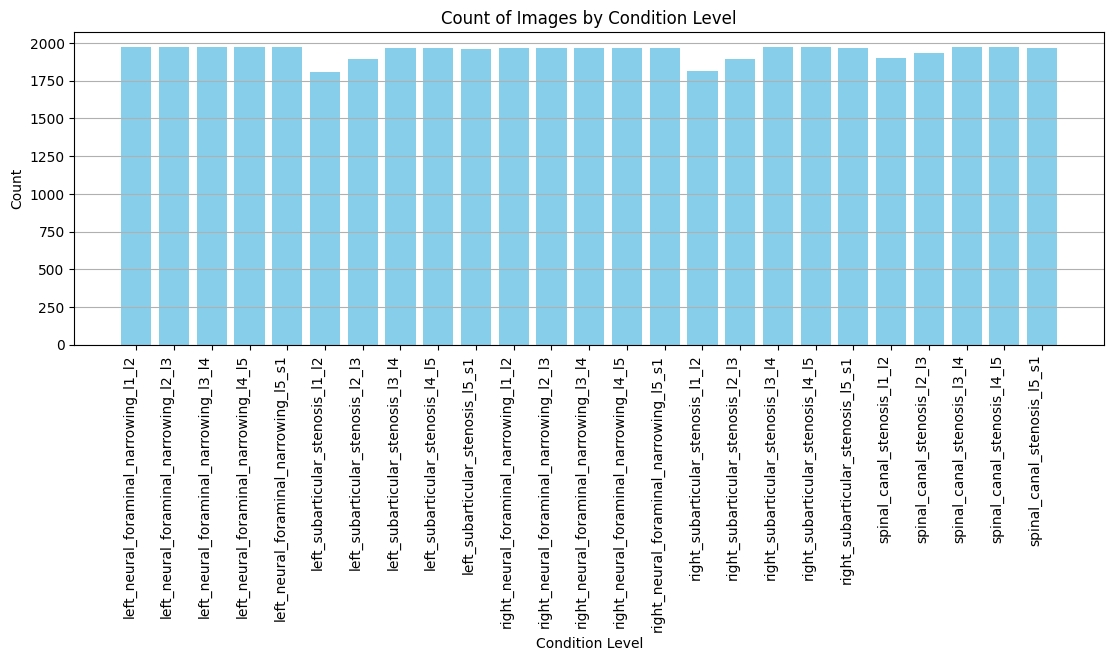

In [36]:
# 棒グラフの描画
plt.figure(figsize=(12, 6))

# アルファベット順に並べたcondition_levelsでデータを並べる
condition_level_counts = df_summary['condition_level'].value_counts()[condition_levels]

plt.bar(condition_level_counts.index, condition_level_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Condition Level')
plt.ylabel('Count')
plt.title('Count of Images by Condition Level')
plt.tight_layout()
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

部位別ではデータは均等に揃っているようだ。

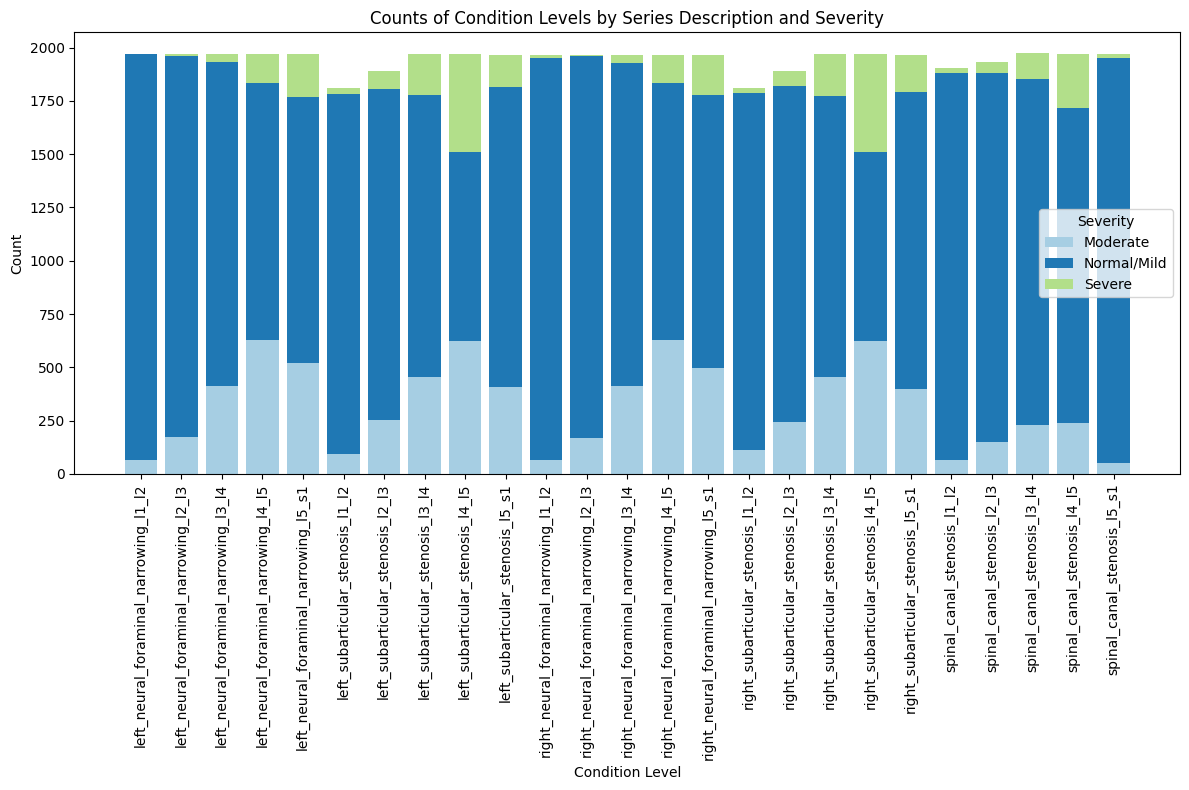

In [37]:
# データの準備
counts = df_summary.groupby(['condition_level', 'severity']).size().unstack(fill_value=0)

# condition_levelの値をリストにしてソート
condition_levels = sorted(df_summary['condition_level'].unique())

# countsをcondition_levelsの順序に並べ替える
counts = counts.loc[condition_levels]

pastel_blue_palette = ["#a6cee3", "#1f78b4", "#b2df8a"]

# グラフの描画
plt.figure(figsize=(12, 8))

bottom = None
for severity, color in zip(counts.columns, pastel_blue_palette):
    plt.bar(counts.index, counts[severity], bottom=bottom, label=severity, color=color)
    if bottom is None:
        bottom = counts[severity].values
    else:
        bottom += counts[severity].values

plt.title('Counts of Condition Levels by Series Description and Severity')
plt.xlabel('Condition Level')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

そもそもシビアのデータが少ない。

重症度による可視化

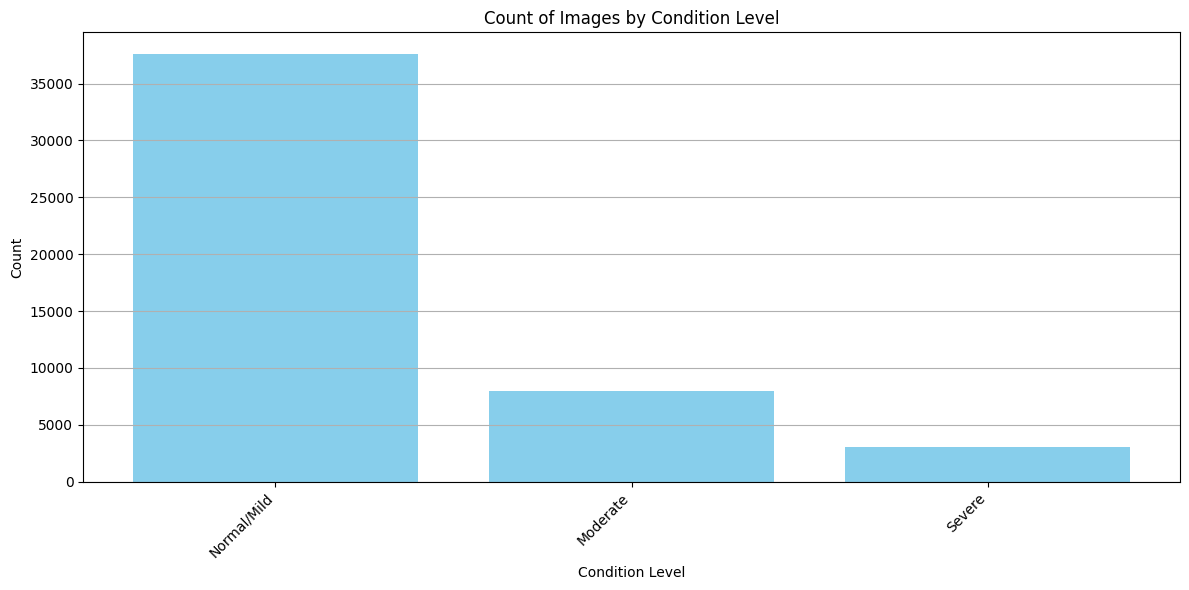

In [38]:
# 棒グラフの描画
plt.figure(figsize=(12, 6))
condition_level_counts = df_summary['severity'].value_counts()
plt.bar(condition_level_counts.index, condition_level_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Condition Level')
plt.ylabel('Count')
plt.title('Count of Images by Condition Level')
plt.tight_layout()
plt.grid(axis='y')

撮影方法による可視化

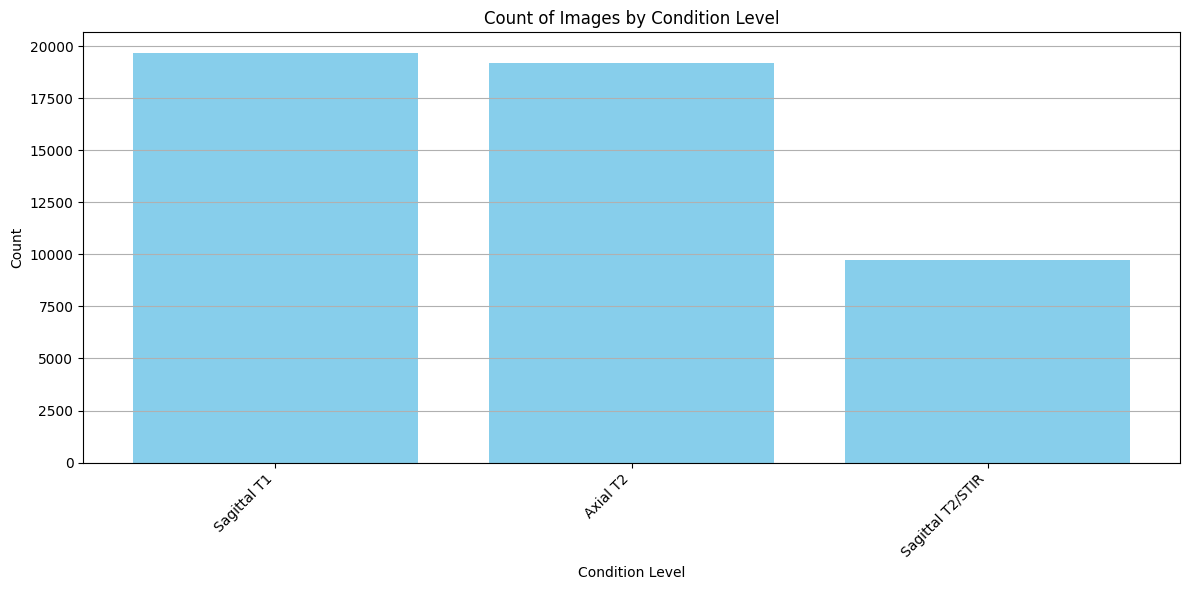

In [39]:
# 棒グラフの描画
plt.figure(figsize=(12, 6))
condition_level_counts = df_summary['series_description'].value_counts()
plt.bar(condition_level_counts.index, condition_level_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Condition Level')
plt.ylabel('Count')
plt.title('Count of Images by Condition Level')
plt.tight_layout()
plt.grid(axis='y')

In [40]:
counts

severity,Moderate,Normal/Mild,Severe
condition_level,,,
left_neural_foraminal_narrowing_l1_l2,1972,1907,2
left_neural_foraminal_narrowing_l2_l3,1972,1791,10
left_neural_foraminal_narrowing_l3_l4,1972,1522,40
left_neural_foraminal_narrowing_l4_l5,1972,1204,140
left_neural_foraminal_narrowing_l5_s1,1972,1247,205
left_subarticular_stenosis_l1_l2,1809,1688,28
left_subarticular_stenosis_l2_l3,1891,1554,83
left_subarticular_stenosis_l3_l4,1970,1323,193
left_subarticular_stenosis_l4_l5,1970,885,461


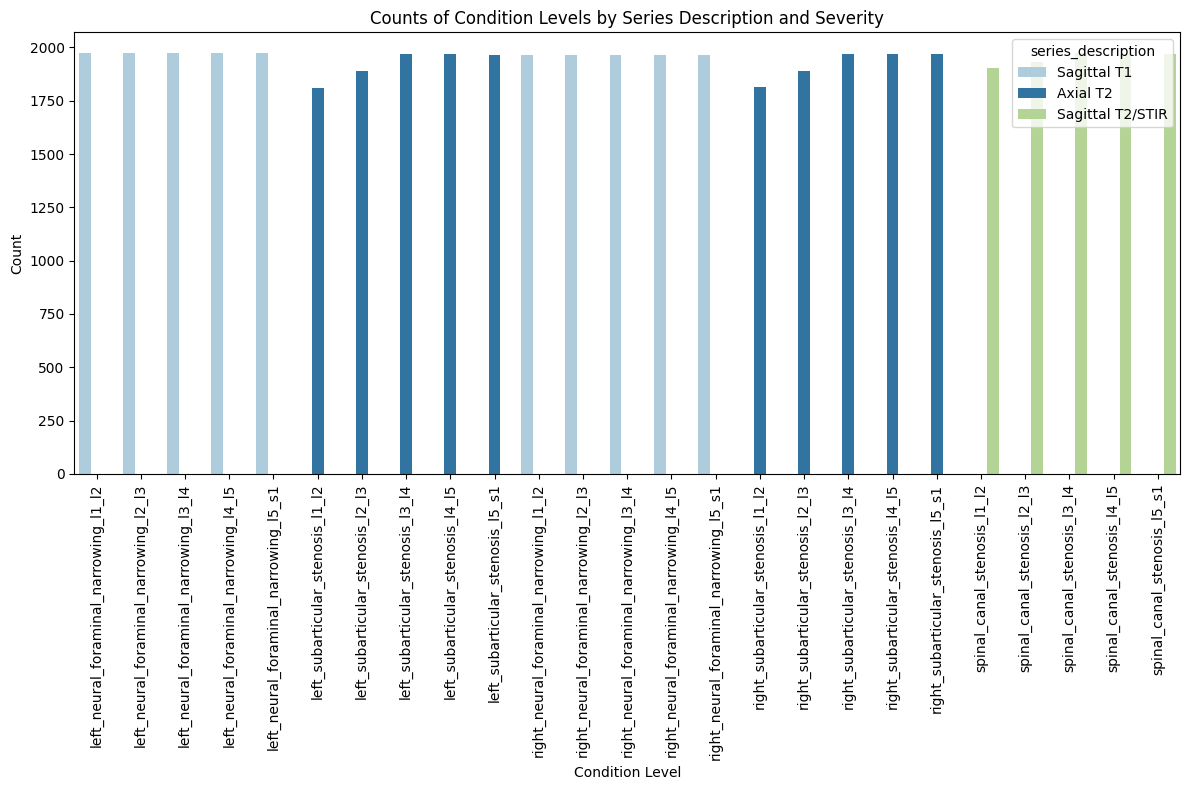

In [41]:
import seaborn as sns

counts = df_summary.groupby(['condition_level', 'series_description']).size().reset_index(name='count')

# グラフの描画
plt.figure(figsize=(12, 8))
sns.barplot(x='condition_level', y='count', hue='series_description', data=counts, palette=pastel_blue_palette)
plt.title('Counts of Condition Levels by Series Description and Severity')
plt.xlabel('Condition Level')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [42]:
counts

,condition_level,series_description,count
0,left_neural_foraminal_narrowing_l1_l2,Sagittal T1,1972
1,left_neural_foraminal_narrowing_l2_l3,Sagittal T1,1972
2,left_neural_foraminal_narrowing_l3_l4,Sagittal T1,1972
3,left_neural_foraminal_narrowing_l4_l5,Sagittal T1,1972
4,left_neural_foraminal_narrowing_l5_s1,Sagittal T1,1972
5,left_subarticular_stenosis_l1_l2,Axial T2,1809
6,left_subarticular_stenosis_l2_l3,Axial T2,1891
7,left_subarticular_stenosis_l3_l4,Axial T2,1970
8,left_subarticular_stenosis_l4_l5,Axial T2,1970
9,left_subarticular_stenosis_l5_s1,Axial T2,1963


In [43]:
total_count = counts['count'].sum()
total_count

48657

In [44]:
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1


In [45]:
severity_mapping = {
    'Normal/Mild': 1,
    'Moderate': 2,
    'Severe': 4
}
df_summary['severity_enc'] = df_summary['severity'].replace(severity_mapping)
df_summary

C:\Users\whand\AppData\Local\Temp\ipykernel_4560\2890206017.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_summary['severity_enc'] = df_summary['severity'].replace(severity_mapping)


,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1


In [46]:
#pip install opencv-python


In [47]:
'''import cv2
import pandas as pd

# 画像サイズを取得して新しいカラムに追加する関数
def get_image_size(image_path):
    try:
        # 画像を読み込む
        image = cv2.imread(image_path)
        # 画像のサイズを取得する
        height, width, channels = image.shape
        return width, height
    except Exception as e:
        print(f"Error while processing {image_path}: {e}")
        return None, None

# 画像サイズを取得して新しいカラムに追加
df_summary['size_x'], df_summary['size_y'] = zip(*df_summary['img_path'].apply(get_image_size))

# 結果の表示
df_summary
'''

'import cv2\nimport pandas as pd\n\n# 画像サイズを取得して新しいカラムに追加する関数\ndef get_image_size(image_path):\n    try:\n        # 画像を読み込む\n        image = cv2.imread(image_path)\n        # 画像のサイズを取得する\n        height, width, channels = image.shape\n        return width, height\n    except Exception as e:\n        print(f"Error while processing {image_path}: {e}")\n        return None, None\n\n# 画像サイズを取得して新しいカラムに追加\ndf_summary[\'size_x\'], df_summary[\'size_y\'] = zip(*df_summary[\'img_path\'].apply(get_image_size))\n\n# 結果の表示\ndf_summary\n'

In [48]:
def get_dicom_image_size(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    return ds.Columns, ds.Rows

# 新しいカラムに画像サイズを追加する
df_summary.loc[:, 'size_x_origin'], df_summary.loc[:, 'size_y_origin'] = zip(*df_summary['img_path_dcm'].apply(get_dicom_image_size))
# 結果を確認する
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1,384,384
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384


In [49]:
def resize_coordinates(x, y, size_x_origin, size_y_origin, new_img_size):
    x_resized = new_img_size[0] / size_x_origin * x
    y_resized = new_img_size[1] / size_y_origin * y
    return x_resized, y_resized

def add_resized_coordinates(df_summary, new_img_size):
    # 新しい座標を計算し、新しいカラムに追加する
    resized_coords = df_summary.apply(lambda row: resize_coordinates(row['x'], row['y'], row['size_x_origin'], row['size_y_origin'], new_img_size), axis=1)
    df_summary['x_new'], df_summary['y_new'] = zip(*resized_coords)
    return df_summary


# 新しい画像サイズ
new_img_size = (128, 128)

# 新しい座標をデータフレームに追加する
df_summary = add_resized_coordinates(df_summary, new_img_size)

# 結果を表示する
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1,384,384,73.155313,32.610354
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,68.446866,46.735695
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.574932,60.337875
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.644444,73.244444


In [50]:
import cv2
# 画像ファイルのパス
image_path = 'train_images_jpg/4290709089/4237840455/12.jpg'  # 実際の画像ファイルのパスに置き換えてください

# 画像を読み込む
image = cv2.imread(image_path)

if image is not None:
    # 画像のサイズを取得する
    height, width, channels = image.shape
    print(f"Image width: {width}, height: {height}")
else:
    print(f"Failed to load image from {image_path}")

Image width: 128, height: 128


In [51]:
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1,384,384,73.155313,32.610354
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,68.446866,46.735695
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.574932,60.337875
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.644444,73.244444


In [52]:
def set_label_data(row):
    # ここでは、各行の条件に基づいてラベルを設定する例を示します
    # 実際のラベル設定ロジックに合わせて修正してください
    label_data = {
        'condition_level': row['condition_level'],
        'x_new': row['x_new'],
        'y_new': row['y_new'],
        'severity_enc': row['severity_enc']
        # 他に必要なラベル情報があれば追加することができます
    }
    return label_data

# 各行に対してラベルデータを設定し、新しい列として追加する
df_summary['label_data'] = df_summary.apply(set_label_data, axis=1)

# 結果を確認する
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new,label_data
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920,{'condition_level': 'spinal_canal_stenosis_l1_...
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857,{'condition_level': 'spinal_canal_stenosis_l2_...
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636,{'condition_level': 'spinal_canal_stenosis_l3_...
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487,{'condition_level': 'spinal_canal_stenosis_l4_...
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920,{'condition_level': 'spinal_canal_stenosis_l5_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1,384,384,73.155313,32.610354,{'condition_level': 'left_neural_foraminal_nar...
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,68.446866,46.735695,{'condition_level': 'left_neural_foraminal_nar...
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.574932,60.337875,{'condition_level': 'left_neural_foraminal_nar...
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.644444,73.244444,{'condition_level': 'left_neural_foraminal_nar...


---

# 画像データの準備

In [53]:
'''# 保存先ディレクトリを指定
save_dir = 'saved_images'
os.makedirs(save_dir, exist_ok=True)

# img_path列にある画像を読み込み、別ファイルに保存
for idx, img_path in enumerate(df_summary['img_path']):
    # 画像を読み込む
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image from path: {img_path}")
        continue  # 画像が読み込めなかった場合はスキップ

    # 保存ファイル名を生成（例として連番を使用）
    save_path = os.path.join(save_dir, f'image_{idx+1}.jpg')

    # 画像を保存
    cv2.imwrite(save_path, image)

    print(f"Saved image to: {save_path}")'''

'# 保存先ディレクトリを指定\nsave_dir = \'saved_images\'\nos.makedirs(save_dir, exist_ok=True)\n\n# img_path列にある画像を読み込み、別ファイルに保存\nfor idx, img_path in enumerate(df_summary[\'img_path\']):\n    # 画像を読み込む\n    image = cv2.imread(img_path)\n    if image is None:\n        print(f"Failed to load image from path: {img_path}")\n        continue  # 画像が読み込めなかった場合はスキップ\n\n    # 保存ファイル名を生成（例として連番を使用）\n    save_path = os.path.join(save_dir, f\'image_{idx+1}.jpg\')\n\n    # 画像を保存\n    cv2.imwrite(save_path, image)\n\n    print(f"Saved image to: {save_path}")'

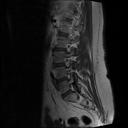

In [54]:
img = Image.open('train_images_jpg/4290709089/4237840455/12.jpg')
img

In [55]:
'''from PIL import Image
import numpy as np

# 画像を NumPy 配列に変換する関数を定義する
def load_image(img_path):
    img = Image.open(img_path)
    img_array = np.array(img, dtype=np.float32)
    return img_array

# 画像のパスを指定する（実際のパスに置き換える必要があります）
img_path = 'train_images_jpg/4003253/702807833/8.jpg'

# 画像を NumPy 配列に変換する
img_array = load_image(img_path)

img_array'''

"from PIL import Image\nimport numpy as np\n\n# 画像を NumPy 配列に変換する関数を定義する\ndef load_image(img_path):\n    img = Image.open(img_path)\n    img_array = np.array(img, dtype=np.float32)\n    return img_array\n\n# 画像のパスを指定する（実際のパスに置き換える必要があります）\nimg_path = 'train_images_jpg/4003253/702807833/8.jpg'\n\n# 画像を NumPy 配列に変換する\nimg_array = load_image(img_path)\n\nimg_array"

In [56]:
'''plt.imshow(img_array.astype(np.uint8))  # float32 を uint8 に変換して表示する場合があります
plt.axis('off')
plt.show()'''

"plt.imshow(img_array.astype(np.uint8))  # float32 を uint8 に変換して表示する場合があります\nplt.axis('off')\nplt.show()"

In [57]:
'''from PIL import Image
import numpy as np
import pandas as pd

# サンプルの load_image 関数を定義する
def load_image(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))# 例として画像を 256x256 にリサイズする
    img_array = np.array(img, dtype=np.float32)
    return img_array

# 画像のパスのリストを取得する
img_paths = df_summary['img_path'].tolist()

# 画像を NumPy 配列に変換して X_train に格納する
X_train = []
for img_path in img_paths:
    img_array = load_image(img_path)
    X_train.append(img_array)

X_train
'''


"from PIL import Image\nimport numpy as np\nimport pandas as pd\n\n# サンプルの load_image 関数を定義する\ndef load_image(img_path):\n    img = Image.open(img_path)\n    img = img.resize((128, 128))# 例として画像を 256x256 にリサイズする\n    img_array = np.array(img, dtype=np.float32)\n    return img_array\n\n# 画像のパスのリストを取得する\nimg_paths = df_summary['img_path'].tolist()\n\n# 画像を NumPy 配列に変換して X_train に格納する\nX_train = []\nfor img_path in img_paths:\n    img_array = load_image(img_path)\n    X_train.append(img_array)\n\nX_train\n"

---

# モデルの構築

## ライブラリ

In [58]:
#pip install tensorflow

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU


* TensorFlowとKerasの関連モジュールをインポートしています。これにより、ニューラルネットワークの構築、訓練、評価が可能になります。

## 畳み込みブロックの定義

In [60]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


* conv_block関数は、2つの畳み込み層（Conv2D）とそれに続くバッチ正規化（BatchNormalization）およびReLU活性化関数（Activation('relu')）からなるブロックを定義しています。
* num_filtersは各畳み込み層のフィルターの数を指定します。

## エンコーダーブロックの定義

In [61]:
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

* encoder_block関数は、畳み込みブロックの出力に対してプーリング操作（MaxPooling2D）を適用します。
* このブロックは、U-Netのエンコーダ（ダウンサンプリング）部分で使用されます。

## デコーダーブロックの定義

In [62]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

* decoder_block関数は、アップサンプリング（UpSampling2D）と連結操作（concatenate）を行います。
* エンコーダの対応する層の出力（concat_tensor）とデコーダの現在の出力を連結し、その後、畳み込みブロックを適用します。
* このブロックは、U-Netのデコーダ（アップサンプリング）部分で使用されます。

## U-Netモデルの定義

In [63]:
def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bridge
    bridge = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bridge, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)

    # Output for severity classification (3 classes: mild, moderate, severe)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs=inputs, outputs=outputs)

    # Custom loss function to ensure probabilities sum to 1
    def custom_loss(y_true, y_pred):
        y_pred /= tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.keras.backend.sum(y_true * tf.keras.backend.log(y_pred), axis=-1)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=custom_loss, metrics=['accuracy', MeanIoU(num_classes=num_classes)])

    return model


* unet関数は、U-Netのエンコーダ、ブリッジ、デコーダ部分を組み合わせてモデルを構築します。
* 入力層は指定された形状（input_shape）を持ち、出力層は指定されたクラス数（num_classes）を持つ1x1の畳み込み層です。
* custom_loss関数は、出力の確率が1になるように正規化し、クロスエントロピー損失を計算するカスタム損失関数です。

## モデルの作成とサマリー

In [64]:
# 使用例
input_shape = (128, 128, 1)  # 画像サイズを適宜変更
num_classes = 3  # 軽度、中等度、重度の3つのクラス

model = unet(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,401,475 (119.79 MB)

 Trainable params: 31,389,699 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [65]:
#model.save('model_1.h5')

* 入力画像の形状とクラス数を指定してU-Netモデルを作成し、モデルの構造を表示します。

In [66]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bridge
    bridge = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bridge, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)

    # Output for severity classification (3 classes: mild, moderate, severe)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs=inputs, outputs=outputs)

    # Custom loss function to ensure probabilities sum to 1
    def custom_loss(y_true, y_pred):
        y_pred /= tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.keras.backend.sum(y_true * tf.keras.backend.log(y_pred), axis=-1)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=custom_loss, metrics=['accuracy', MeanIoU(num_classes=num_classes)])

    return model

# 使用例
input_shape = (128, 128, 1)  # 画像サイズを適宜変更
num_classes = 3  # 軽度、中等度、重度の3つのクラス

model = unet(input_shape, num_classes)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,401,475 (119.79 MB)

 Trainable params: 31,389,699 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

---

df_summary

In [67]:
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new,label_data
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920,{'condition_level': 'spinal_canal_stenosis_l1_...
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857,{'condition_level': 'spinal_canal_stenosis_l2_...
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636,{'condition_level': 'spinal_canal_stenosis_l3_...
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487,{'condition_level': 'spinal_canal_stenosis_l4_...
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920,{'condition_level': 'spinal_canal_stenosis_l5_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1,384,384,73.155313,32.610354,{'condition_level': 'left_neural_foraminal_nar...
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,68.446866,46.735695,{'condition_level': 'left_neural_foraminal_nar...
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.574932,60.337875,{'condition_level': 'left_neural_foraminal_nar...
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.644444,73.244444,{'condition_level': 'left_neural_foraminal_nar...


# モデルの学習（サンプル）

In [68]:
labels = df_summary['label_data'].tolist()
labels_ex = labels[:50]
labels_ex

[{'condition_level': 'spinal_canal_stenosis_l1_l2',
  'x_new': 64.56637168141593,
  'y_new': 45.5929203539823,
  'severity_enc': 1},
 {'condition_level': 'spinal_canal_stenosis_l2_l3',
  'x_new': 64.11428571428571,
  'y_new': 59.142857142857146,
  'severity_enc': 1},
 {'condition_level': 'spinal_canal_stenosis_l3_l4',
  'x_new': 64.60606060606061,
  'y_new': 74.36363636363636,
  'severity_enc': 1},
 {'condition_level': 'spinal_canal_stenosis_l4_l5',
  'x_new': 67.05840707964602,
  'y_new': 85.46548672566372,
  'severity_enc': 1},
 {'condition_level': 'spinal_canal_stenosis_l5_s1',
  'x_new': 70.68318584070796,
  'y_new': 96.79292035398231,
  'severity_enc': 1},
 {'condition_level': 'right_neural_foraminal_narrowing_l4_l5',
  'x_new': 62.65391969407265,
  'y_new': 83.94646271510516,
  'severity_enc': 2},
 {'condition_level': 'right_neural_foraminal_narrowing_l5_s1',
  'x_new': 66.08030592734227,
  'y_new': 95.20458891013382,
  'severity_enc': 1},
 {'condition_level': 'right_neural_foram

In [69]:
df_summary

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new,label_data
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920,{'condition_level': 'spinal_canal_stenosis_l1_...
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857,{'condition_level': 'spinal_canal_stenosis_l2_...
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636,{'condition_level': 'spinal_canal_stenosis_l3_...
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487,{'condition_level': 'spinal_canal_stenosis_l4_...
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920,{'condition_level': 'spinal_canal_stenosis_l5_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,left_neural_foraminal_narrowing,l1_l2,left_neural_foraminal_narrowing_l1_l2,219.465940,97.831063,4290709089_left_neural_foraminal_narrowing_l1_l2,train_images_jpg/4290709089/4237840455/11.jpg,train_images/4290709089/4237840455/11.dcm,Normal/Mild,Sagittal T1,1,384,384,73.155313,32.610354,{'condition_level': 'left_neural_foraminal_nar...
48688,4290709089,4237840455,12,left_neural_foraminal_narrowing,l2_l3,left_neural_foraminal_narrowing_l2_l3,205.340599,140.207084,4290709089_left_neural_foraminal_narrowing_l2_l3,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,68.446866,46.735695,{'condition_level': 'left_neural_foraminal_nar...
48689,4290709089,4237840455,12,left_neural_foraminal_narrowing,l3_l4,left_neural_foraminal_narrowing_l3_l4,202.724796,181.013624,4290709089_left_neural_foraminal_narrowing_l3_l4,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.574932,60.337875,{'condition_level': 'left_neural_foraminal_nar...
48690,4290709089,4237840455,12,left_neural_foraminal_narrowing,l4_l5,left_neural_foraminal_narrowing_l4_l5,202.933333,219.733333,4290709089_left_neural_foraminal_narrowing_l4_l5,train_images_jpg/4290709089/4237840455/12.jpg,train_images/4290709089/4237840455/12.dcm,Normal/Mild,Sagittal T1,1,384,384,67.644444,73.244444,{'condition_level': 'left_neural_foraminal_nar...


* memo
    * train_images.zip(28.2GB)のダウンロードに3時間かかった。(7/7)
    * df_summaryにデータを集約、前処理実施(7/8)

In [70]:
'''# ダミーの画像データとラベルデータを作成する例
import numpy as np

# ダミーの画像データ
dummy_images = np.random.rand(100, 128, 128, 1)  # 100枚の128x128のグレースケール画像

# ダミーのラベルデータ（3クラス分類）
dummy_labels = np.random.randint(0, 3, (100, 128, 128))

# ラベルデータをone-hotエンコーディングに変換
from keras.utils import to_categorical
dummy_labels_onehot = to_categorical(dummy_labels, num_classes=3)

# モデルを作成
model = unet(input_shape=(128, 128, 1), num_classes=3)

# モデルの学習
model.fit(dummy_images, dummy_labels_onehot, batch_size=8, epochs=10, validation_split=0.2)
'''

'# ダミーの画像データとラベルデータを作成する例\nimport numpy as np\n\n# ダミーの画像データ\ndummy_images = np.random.rand(100, 128, 128, 1)  # 100枚の128x128のグレースケール画像\n\n# ダミーのラベルデータ（3クラス分類）\ndummy_labels = np.random.randint(0, 3, (100, 128, 128))\n\n# ラベルデータをone-hotエンコーディングに変換\nfrom keras.utils import to_categorical\ndummy_labels_onehot = to_categorical(dummy_labels, num_classes=3)\n\n# モデルを作成\nmodel = unet(input_shape=(128, 128, 1), num_classes=3)\n\n# モデルの学習\nmodel.fit(dummy_images, dummy_labels_onehot, batch_size=8, epochs=10, validation_split=0.2)\n'

In [71]:
'''# テストデータの準備
dummy_test_images = np.random.rand(20, 128, 128, 1)  # 20枚の128x128のグレースケール画像
dummy_test_labels = np.random.randint(0, 3, (20, 128, 128))
dummy_test_labels_onehot = to_categorical(dummy_test_labels, num_classes=3)

# モデルの評価
loss, accuracy, mean_iou = model.evaluate(dummy_test_images, dummy_test_labels_onehot, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
'''

'# テストデータの準備\ndummy_test_images = np.random.rand(20, 128, 128, 1)  # 20枚の128x128のグレースケール画像\ndummy_test_labels = np.random.randint(0, 3, (20, 128, 128))\ndummy_test_labels_onehot = to_categorical(dummy_test_labels, num_classes=3)\n\n# モデルの評価\nloss, accuracy, mean_iou = model.evaluate(dummy_test_images, dummy_test_labels_onehot, verbose=1)\nprint(f"Test Loss: {loss:.4f}")\nprint(f"Test Accuracy: {accuracy:.4f}")\nprint(f"Mean IoU: {mean_iou:.4f}")\n'

---

# Unetでセグメンテーションモデルの作成

ライブラリ

In [72]:
#pip install scikit-image

In [73]:
'''#ライブラリ
import pydicom
import numpy as np
from skimage.transform import resize
from skimage.draw import polygon
import pandas as pd'''

'#ライブラリ\nimport pydicom\nimport numpy as np\nfrom skimage.transform import resize\nfrom skimage.draw import polygon\nimport pandas as pd'

In [74]:
'''#DICOM画像の読み込み関数
def read_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    return image

#画像の前処理関数
def preprocess_image(image, target_size=(128, 128)):
    image_resized = resize(image, target_size, anti_aliasing=True)
    image_normalized = image_resized / np.max(image_resized)
    return image_normalized

#マスク生成関数
def generate_mask(image_shape, x_coords, y_coords):
    mask = np.zeros(image_shape, dtype=np.uint8)
    rr, cc = polygon(y_coords, x_coords)
    mask[rr, cc] = 1
    return mask

#画像とマスクを読み込み、前処理する関数
def load_image_and_mask(df, index, target_size=(128, 128)):
    img_path = df.iloc[index]['img_path']
    
    x_coords = df.iloc[index]['x']
    y_coords = df.iloc[index]['y']
    
    image = read_dicom_image(img_path)
    mask = generate_mask(image.shape, x_coords, y_coords)
    
    image = preprocess_image(image, target_size)
    mask = preprocess_image(mask, target_size)
    
    return image, mask

import pydicom
import numpy as np
from skimage.transform import resize
from skimage.draw import polygon
import pandas as pd
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, batch_size=8, target_size=(128, 128)):
        self.df = df
        self.batch_size = batch_size
        self.target_size = target_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        pass  # 通常はエポックの終了時にシャッフルなどの処理を行いますが、今回はスキップします。

    def __data_generation(self, batch_df):
        X = np.zeros((self.batch_size, *self.target_size, 1))
        y = np.zeros((self.batch_size, *self.target_size, 1))

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = row['img_path_dcm']
            x_coords = row['x_new']
            y_coords = row['y_new']

            image = self.read_dicom_image(img_path)
            mask = self.generate_mask(image.shape, x_coords, y_coords)

            image = self.preprocess_image(image, self.target_size)
            mask = self.preprocess_image(mask, self.target_size)

            X[i,] = image[..., np.newaxis]
            y[i,] = mask[..., np.newaxis]

        return X, y

    @staticmethod
    def read_dicom_image(file_path):
        dicom = pydicom.dcmread(file_path)
        image = dicom.pixel_array
        return image

    @staticmethod
    def preprocess_image(image, target_size=(128, 128)):
        image_resized = resize(image, target_size, anti_aliasing=True)
        image_normalized = image_resized / np.max(image_resized)
        return image_normalized

    @staticmethod
    def generate_mask(image_shape, x_coords, y_coords):
        mask = np.zeros(image_shape, dtype=np.uint8)
        rr, cc = polygon(y_coords, x_coords)
        mask[rr, cc] = 1
        return mask'''


"#DICOM画像の読み込み関数\ndef read_dicom_image(file_path):\n    dicom = pydicom.dcmread(file_path)\n    image = dicom.pixel_array\n    return image\n\n#画像の前処理関数\ndef preprocess_image(image, target_size=(128, 128)):\n    image_resized = resize(image, target_size, anti_aliasing=True)\n    image_normalized = image_resized / np.max(image_resized)\n    return image_normalized\n\n#マスク生成関数\ndef generate_mask(image_shape, x_coords, y_coords):\n    mask = np.zeros(image_shape, dtype=np.uint8)\n    rr, cc = polygon(y_coords, x_coords)\n    mask[rr, cc] = 1\n    return mask\n\n#画像とマスクを読み込み、前処理する関数\ndef load_image_and_mask(df, index, target_size=(128, 128)):\n    img_path = df.iloc[index]['img_path']\n    \n    x_coords = df.iloc[index]['x']\n    y_coords = df.iloc[index]['y']\n    \n    image = read_dicom_image(img_path)\n    mask = generate_mask(image.shape, x_coords, y_coords)\n    \n    image = preprocess_image(image, target_size)\n    mask = preprocess_image(mask, target_size)\n    \n    return image

In [75]:
'''#モデルの訓練
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    up3 = UpSampling2D(size=(2, 2))(pool2)
    merge3 = Concatenate()([conv2, up3])
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(merge3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    
    up4 = UpSampling2D(size=(2, 2))(conv3)
    merge4 = Concatenate()([conv1, up4])
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    
    conv5 = Conv2D(1, 1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, outputs=conv5)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# データフレームやパス、バッチサイズを適切に設定してデータジェネレータを作成します
batch_size = 8
train_generator = DataGenerator(df_summary, batch_size)

# モデルを作成し、データジェネレータを使って訓練します
model = unet_model(input_size=(128, 128, 1))
model.fit(train_generator, epochs=50, steps_per_epoch=len(df_summary) // batch_size)'''



"#モデルの訓練\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate\n\ndef unet_model(input_size=(128, 128, 1)):\n    inputs = Input(input_size)\n    \n    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)\n    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)\n    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n    \n    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)\n    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)\n    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n    \n    up3 = UpSampling2D(size=(2, 2))(pool2)\n    merge3 = Concatenate()([conv2, up3])\n    conv3 = Conv2D(128, 3, activation='relu', padding='same')(merge3)\n    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)\n    \n    up4 = UpSampling2D(size=(2, 2))(conv3)\n    merge4 = Concatenate()([conv1, up4])\n    conv4 = Conv2D(64, 3, activation='relu', padding='same')

990min

---

In [76]:
df_summary.to_csv('df_summary.csv', index=False)

---

# セグメンテーションマスクの生成

In [77]:
df_summary_plus = df_summary[:10]

In [78]:
df_summary_plus

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new,label_data
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920,{'condition_level': 'spinal_canal_stenosis_l1_...
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857,{'condition_level': 'spinal_canal_stenosis_l2_...
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636,{'condition_level': 'spinal_canal_stenosis_l3_...
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487,{'condition_level': 'spinal_canal_stenosis_l4_...
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920,{'condition_level': 'spinal_canal_stenosis_l5_...
5,4003253,1054713880,4,right_neural_foraminal_narrowing,l4_l5,right_neural_foraminal_narrowing_l4_l5,187.961759,251.839388,4003253_right_neural_foraminal_narrowing_l4_l5,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Moderate,Sagittal T1,2,384,384,62.653920,83.946463,{'condition_level': 'right_neural_foraminal_na...
6,4003253,1054713880,4,right_neural_foraminal_narrowing,l5_s1,right_neural_foraminal_narrowing_l5_s1,198.240918,285.613767,4003253_right_neural_foraminal_narrowing_l5_s1,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Normal/Mild,Sagittal T1,1,384,384,66.080306,95.204589,{'condition_level': 'right_neural_foraminal_na...
7,4003253,1054713880,5,right_neural_foraminal_narrowing,l3_l4,right_neural_foraminal_narrowing_l3_l4,187.227533,210.722753,4003253_right_neural_foraminal_narrowing_l3_l4,train_images_jpg/4003253/1054713880/5.jpg,train_images/4003253/1054713880/5.dcm,Moderate,Sagittal T1,2,384,384,62.409178,70.240918,{'condition_level': 'right_neural_foraminal_na...
8,4003253,1054713880,6,right_neural_foraminal_narrowing,l1_l2,right_neural_foraminal_narrowing_l1_l2,194.569790,127.755258,4003253_right_neural_foraminal_narrowing_l1_l2,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild,Sagittal T1,1,384,384,64.856597,42.585086,{'condition_level': 'right_neural_foraminal_na...
9,4003253,1054713880,6,right_neural_foraminal_narrowing,l2_l3,right_neural_foraminal_narrowing_l2_l3,191.632887,165.934990,4003253_right_neural_foraminal_narrowing_l2_l3,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild,Sagittal T1,1,384,384,63.877629,55.311663,{'condition_level': 'right_neural_foraminal_na...


In [79]:
import os
import pydicom
import numpy as np
import cv2

# 入力と出力のフォルダパスを設定します
input_folder = 'train_images'  # DICOM画像のフォルダパスを設定してください
output_folder = 'train_seg'  # セグメンテーションマスクを保存するフォルダパスを設定してください

# DataFrameから画像パスと座標のリストを取得します
img_paths = df_summary['img_path_dcm'].tolist()
x_coords = df_summary['x'].tolist()
y_coords = df_summary['y'].tolist()

# 各画像について処理を行います
for img_path_dcm, x, y in zip(img_paths, x_coords, y_coords):
    # 画像のファイル名を取得します
    filename = os.path.basename(img_path_dcm)
    
    # DICOM画像を読み込みます
    dcm = pydicom.dcmread(img_path_dcm)
    
    # DICOM画像からnumpy配列に変換します
    img_array = dcm.pixel_array
    
    # セグメンテーションマスクの初期化（ゼロ配列を生成）
    segmentation_mask = np.zeros_like(img_array, dtype=np.uint8)
    
    # 座標情報を使ってセグメンテーションマスクを作成します
    # 例えば、単純に指定座標をセグメントする場合
    # ここでは単純に1をセグメントする例を示しますが、実際のセグメンテーション処理に応じて修正してください
    segmentation_mask[int(y), int(x)] = 1

    df_summary['img_seg'].loc[df_summary['img_path_dcm'] == img_path_dcm] = seg_mask_path





NameError: name 'seg_mask_path' is not defined

In [ ]:
df_summary[:10]

,study_id,series_id,instance_number,condition,level,condition_level,x,y,row_id,img_path,img_path_dcm,severity,series_description,severity_enc,size_x_origin,size_y_origin,x_new,y_new,label_data,img_seg
0,4003253,702807833,8,spinal_canal_stenosis,l1_l2,spinal_canal_stenosis_l1_l2,322.831858,227.964602,4003253_spinal_canal_stenosis_l1_l2,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.566372,45.592920,{'condition_level': 'spinal_canal_stenosis_l1_...,img_seg/7.jpg
1,4003253,702807833,8,spinal_canal_stenosis,l2_l3,spinal_canal_stenosis_l2_l3,320.571429,295.714286,4003253_spinal_canal_stenosis_l2_l3,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.114286,59.142857,{'condition_level': 'spinal_canal_stenosis_l2_...,img_seg/7.jpg
2,4003253,702807833,8,spinal_canal_stenosis,l3_l4,spinal_canal_stenosis_l3_l4,323.030303,371.818182,4003253_spinal_canal_stenosis_l3_l4,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,64.606061,74.363636,{'condition_level': 'spinal_canal_stenosis_l3_...,img_seg/7.jpg
3,4003253,702807833,8,spinal_canal_stenosis,l4_l5,spinal_canal_stenosis_l4_l5,335.292035,427.327434,4003253_spinal_canal_stenosis_l4_l5,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,67.058407,85.465487,{'condition_level': 'spinal_canal_stenosis_l4_...,img_seg/7.jpg
4,4003253,702807833,8,spinal_canal_stenosis,l5_s1,spinal_canal_stenosis_l5_s1,353.415929,483.964602,4003253_spinal_canal_stenosis_l5_s1,train_images_jpg/4003253/702807833/8.jpg,train_images/4003253/702807833/8.dcm,Normal/Mild,Sagittal T2/STIR,1,640,640,70.683186,96.792920,{'condition_level': 'spinal_canal_stenosis_l5_...,img_seg/7.jpg
5,4003253,1054713880,4,right_neural_foraminal_narrowing,l4_l5,right_neural_foraminal_narrowing_l4_l5,187.961759,251.839388,4003253_right_neural_foraminal_narrowing_l4_l5,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Moderate,Sagittal T1,2,384,384,62.653920,83.946463,{'condition_level': 'right_neural_foraminal_na...,img_seg/7.jpg
6,4003253,1054713880,4,right_neural_foraminal_narrowing,l5_s1,right_neural_foraminal_narrowing_l5_s1,198.240918,285.613767,4003253_right_neural_foraminal_narrowing_l5_s1,train_images_jpg/4003253/1054713880/4.jpg,train_images/4003253/1054713880/4.dcm,Normal/Mild,Sagittal T1,1,384,384,66.080306,95.204589,{'condition_level': 'right_neural_foraminal_na...,img_seg/7.jpg
7,4003253,1054713880,5,right_neural_foraminal_narrowing,l3_l4,right_neural_foraminal_narrowing_l3_l4,187.227533,210.722753,4003253_right_neural_foraminal_narrowing_l3_l4,train_images_jpg/4003253/1054713880/5.jpg,train_images/4003253/1054713880/5.dcm,Moderate,Sagittal T1,2,384,384,62.409178,70.240918,{'condition_level': 'right_neural_foraminal_na...,img_seg/7.jpg
8,4003253,1054713880,6,right_neural_foraminal_narrowing,l1_l2,right_neural_foraminal_narrowing_l1_l2,194.569790,127.755258,4003253_right_neural_foraminal_narrowing_l1_l2,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild,Sagittal T1,1,384,384,64.856597,42.585086,{'condition_level': 'right_neural_foraminal_na...,img_seg/7.jpg
9,4003253,1054713880,6,right_neural_foraminal_narrowing,l2_l3,right_neural_foraminal_narrowing_l2_l3,191.632887,165.934990,4003253_right_neural_foraminal_narrowing_l2_l3,train_images_jpg/4003253/1054713880/6.jpg,train_images/4003253/1054713880/6.dcm,Normal/Mild,Sagittal T1,1,384,384,63.877629,55.311663,{'condition_level': 'right_neural_foraminal_na...,img_seg/7.jpg


In [ ]:
import os
import cv2
import pydicom

# DICOM画像を読み込む関数
def load_dicom_image(image_path):
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    return img

# セグメンテーションマスク画像を赤色に変換する関数
def mask_to_red(mask_image):
    # マスク画像を赤色に変換する（赤色のBGR値を設定）
    red_mask = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
    red_mask[:,:,0] = 0  # Bチャンネルを0に
    red_mask[:,:,1] = 0  # Gチャンネルを0に
    red_mask[red_mask > 0] = 255  # マスク部分を赤色にする

    return red_mask

# MRI画像にマスク画像を重ねて表示する関数
def overlay_mask_on_mri(mri_image, mask_image):
    # 赤色に変換したマスク画像を合成する
    overlay = cv2.addWeighted(mask_image, 0.5, mri_image, 0.5, 0)

    return overlay

# DICOM画像とセグメンテーションマスク画像のパス
dicom_path = 'path_to_dicom_image.dcm'
mask_path = 'path_to_segmentation_mask.jpg'

# DICOM画像とマスク画像を読み込む
mri_image = load_dicom_image(dicom_path)
mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# マスク画像を赤色に変換
red_mask = mask_to_red(mask_image)

# MRI画像に赤色のマスク画像を重ねて表示
overlay = overlay_mask_on_mri(mri_image, red_mask)

# 画像を表示する
cv2.imshow('MRI with Red Segmentation Mask', overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
X_train_list = df_summary['img_path'].tolist()

X_train = []

# X_trainに含まれる各画像パスに対してループ処理を行う
for image_path in X_train_list:
    # 画像をPIL Imageとして読み込む
    image_pil = Image.open(image_path)
    
    # PIL Imageをnumpy配列に変換
    image_np = np.array(image_pil)
    
    # 必要に応じて前処理を行う（例：正規化など）
    # 例えば、画像を0から1の範囲に正規化する場合
    image_np = image_np / 255.0
    
    # 変換したnumpy配列をX_train_npに追加する
    X_train.append(image_np)


In [ ]:
X_train

[array([[0.01960784, 0.01960784, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        [0.01960784, 0.01960784, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        [0.01960784, 0.01960784, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01568627, 0.01568627, 0.01568627, ..., 0.        , 0.        ,
         0.        ],
        [0.01568627, 0.01568627, 0.01568627, ..., 0.        , 0.        ,
         0.        ],
        [0.01568627, 0.01568627, 0.01568627, ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.01960784, 0.01960784, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        [0.01960784, 0.01960784, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        [0.01960784, 0.01960784, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01568627, 0.01568627, 0.01568627, ..., 0.        , 0.        ,
         0.        ],
        [0.0